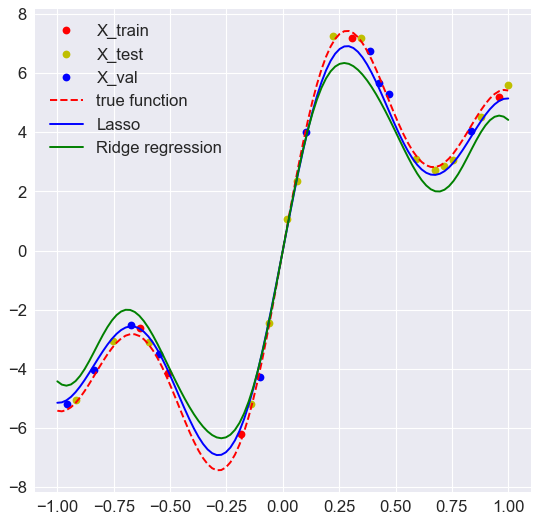

In [18]:
%matplotlib inline
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as pl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model
import pdb
import random
import pylab as pl

# X is an array of N data points (one dimensional for now), that is, NX1
# Y is a Nx1 column vector of data values

def getData(name):
    data = pl.loadtxt(name)
    # Returns column matrices
    X = data[0:1].T
    Y = data[1:2].T
    return X, Y

def lassoTrainData():
    return getData('lasso_train.txt')

def lassoValData():
    return getData('lasso_validate.txt')

def lassoTestData():
    return getData('lasso_test.txt')

def getW_true():
    return pl.loadtxt('lasso_true_w.txt')

def lasso_weights(X_train, y_train, lambd=0.1):
    clf = linear_model.Lasso(lambd)
    clf.fit(X_train, y_train)
    return clf.coef_

def l2_weights(X_train, y_train, lambd=0.1):
    clf = linear_model.Ridge(lambd)
    clf.fit(X_train, y_train)
    return clf.coef_

def phi(x):
    X = np.array(x)
    for i in range(12):
        X = np.hstack((X, np.sin(0.4*np.pi*x*(i+1))))
    return X

def true_function(X):
    theta = getW_true()
    A = np.dot(X, theta)
    return A

# The function fits the Lasso regularizer for the Training dataset
# provided. This gives the weights from the training dataset which
# is used to fit the X values
def predict_lasso(X_train, Y_train, X):
    theta = lasso_weights(X_train, Y_train)
    return np.dot(X, theta)

def ridge_weights(X, Y, lambd=0.1, M=12):
    theta = np.dot(np.linalg.inv(lambd*np.identity(M+1) + (np.dot(X.T, X))), np.dot(X.T, Y))
    return theta[:,0]

def ridge_regression(X_train, Y_train, X, lambd=1.0):
    theta = ridge_weights(X_train, Y_train, lambd, 12)
    return np.dot(X, theta)

if __name__ == '__main__':
    X_train, y_train = lassoTrainData()
    X_test, y_test = lassoTestData()
    X_val, y_val = lassoValData()
    w_true = getW_true()

    plt.figure(1,figsize=(8,8), dpi=80)
    plt.plot(X_train, y_train,'ro', label='X_train')
    plt.plot(X_test, y_test, 'yo', label='X_test')
    plt.plot(X_val, y_val, 'bo', label='X_val')
    
    X_tr = np.linspace(-1.0, 1.0, 100).reshape((100,1))
    plt.plot(X_tr, true_function(phi(X_tr)), 'r--', label='true function')
    plt.plot(X_tr, predict_lasso(phi(X_train), y_train, phi(X_tr)), 'b-', label='Lasso')
    plt.plot(X_tr, ridge_regression(phi(X_train), y_train, phi(X_tr)), 'g-', label='Ridge regression')
    
    # TODO: lambda = 0
    #plt.plot(X_tr, ridge_regression(phi(X_train), y_train, phi(X_tr), 0.0), '-', label='lambda 0')
    
    plt.legend(loc='upper left')


[0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]


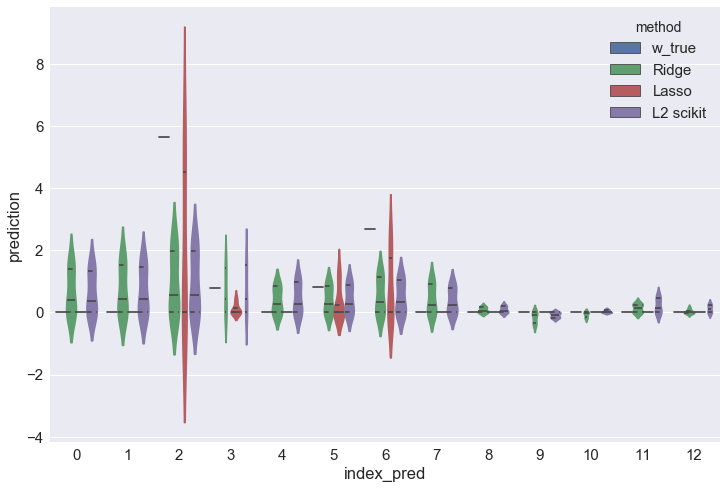

In [29]:
w_lambda0 = ridge_weights(phi(X_train), y_train, 0.0)
w_ridge_1e_1 = ridge_weights(phi(X_train), y_train, 0.1)
w_lasso_1e_1 = lasso_weights(phi(X_train), y_train, 0.1)
w_l2_1e_1 = l2_weights(phi(X_train), y_train, 1e-6)

def prep_df(inputlist):
    columns = ['method', 'lambda', 'predicted']
    df_predictions = pd.DataFrame(inputlist,  columns=columns)
    df_predictions = pd.concat([df_predictions.drop(['predicted'], axis=1), df_predictions['predicted'].apply(pd.Series)], axis=1)
    df_predictions.index = df_predictions[['method', 'lambda']]
    df_predictions = df_predictions.drop(['method', 'lambda'], axis = 1)
    df_predictions = df_predictions.unstack().reset_index()
    df_predictions.columns = ['index_pred', 'parameters', 'prediction']
    df_predictions = pd.concat([df_predictions.drop(['parameters'], axis=1), df_predictions['parameters'].apply(pd.Series)], axis=1)
    df_predictions.columns = ['index_pred', 'prediction', 'method', 'lambda']
    return df_predictions

# Range of Lambda values which affect the Lasso prediction
Lambd = list(range(-2, 6, 1))
Lambd = [10**i for i in Lambd]
Lambd = [float(i) for i in Lambd]
print Lambd
#w_lambda0 = ridge_weights(phi(X_train), y_train, 0.0)
#print(w_lambda0)
w_lambda0 = [("lambda0", 0, dict(enumerate(ridge_weights(phi(X_train), y_train, 0))))]
df_w_lambda0 = prep_df(w_lambda0)

w_true_np = [("w_true", 0, dict(enumerate(w_true)))]
df_true = prep_df(w_true_np)
#print(df_true)

w_ridge_1e_1 = [("Ridge", i, dict(enumerate(ridge_weights(phi(X_train), y_train, i)))) for i in Lambd]
df_ridge = prep_df(w_ridge_1e_1)
w_lasso_1e_1 = [("Lasso", i, dict(enumerate(lasso_weights(phi(X_train), y_train, i)))) for i in Lambd]
df_lasso = prep_df(w_lasso_1e_1)
w_l2_1e_1 = [("L2 scikit", i, dict(enumerate(l2_weights(phi(X_train), y_train, i)[0]))) for i in Lambd]
df_12weights = prep_df(w_l2_1e_1)

df_all = pd.concat([df_true, df_ridge,df_lasso,df_12weights ]) # include df_w_lambda0 in the list of data frames if you want to include in in plot 
#print(df_all.head())

# Scatter plot
#f, ax = plt.subplots(figsize=(12, 8))
#sns.set(font_scale=1.5)
#ax = sns.stripplot(x="index_pred", y="prediction", data=df_all, hue='method', jitter=0.1)

f, ax = plt.subplots(figsize=(12, 8))
sns.set(font_scale=1.5)
ax = sns.violinplot(x="index_pred", y="prediction", hue="method", data=df_all,
               inner="quart")
